In [1]:
#must install folium, hdbscan, and geopy

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [3]:
import pandas as pd
import folium
import urllib.request, json, pprint 
import numpy as np
import hdbscan
from hdbscan import *
import matplotlib.pyplot as plt

import sklearn
from sklearn import cluster 
from sklearn.neighbors import KNeighborsClassifier

https://python-visualization.github.io/folium/modules.html   
https://nbviewer.jupyter.org/github/python-visualization/folium_contrib/tree/master/notebooks/   
https://python-visualization.github.io/folium/quickstart.html#Markers   
https://python-visualization.github.io/folium/quickstart.html

In [4]:
import math
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    lon1, lat1, lon2, lat2 = map(math.radians, [float(lon1), float(lat1), float(lon2), float(lat2)])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [5]:
from geopy import *
from geopy.geocoders import Nominatim

def get_lat_long_from_address(address):
    geolocator = Nominatim(user_agent="specify_your_app_name_here")
    location = geolocator.geocode(address)
    return location.latitude, location.longitude


## The basic premise of this project is that we can establish an x by y 2D matrix and color code the inner grid squares based on the density of crimes. 

## We first set how many horizontal (lat grids) and vertical (long grids) we will use. Then set the upper left and lower right corners of the geographic space we're mapping.

## After we set the boundaries the latitude and longitude values for each grid square are calculated by dividing the absolute difference by the number of grids specified.

In [23]:
lat_num_grids = 15
long_num_grids = 30

chicago_x1 = 42.019820
chicago_x2 = 41.644334
chicago_y1 = -87.855531
chicago_y2 = -87.526281

chicago_lat_diff = abs(chicago_x1-chicago_x2)
chicago_long_diff = abs(chicago_y1 - chicago_y2)

lat_grid_size = chicago_lat_diff / lat_num_grids
long_grid_size = chicago_long_diff/long_num_grids

grid_x = [chicago_x1 - (i*lat_grid_size) for i in range(lat_num_grids)]
grid_y = [chicago_y1 + (i*long_grid_size) for i in range(long_num_grids)]

points = []
for y in grid_y:
    for x in grid_x:
        points.append([x, y, x-lat_grid_size, y+long_grid_size])

## The API for chicago's crime data is set and queried so we get a JSON object back. 
## We're using urllib.request for the url and json.loads to take in the results directly.

In [24]:
chicago_crime_url = "https://data.cityofchicago.org/resource/6zsd-86xi.json"
    
def get_chicago_crime_data(c_url):    
    #import urllib.request, json, pprint 
    with urllib.request.urlopen(chicago_crime_url) as url:
        return json.loads(url.read().decode())


## The free API is rate limited, therefore we check to make sure we have more than 10 (arbitrary low number) of observations. If we don't we requery the API to get a true sample.

In [25]:
data = get_chicago_crime_data(chicago_crime_url)

def test_len(d):
    if len(d) < 10: 
        d = get_chicago_crime_data(chicago_crime_url)
        test_len(d)
    else:
        return d

data = test_len(data)
print("Number of observations: " + str(len(data)))

Number of observations: 1000


## We calculate the mid-point for every grid suqare and store them in a list. We will use this to calculate haversine distances from crime observations to grid mid-points. 

In [26]:
# calculate mid-point of grids

mid_points = {}
for id,_ in enumerate(points):
    a = [.5*(_[0]-_[2])+_[0], .5*(_[1]-_[3])+_[3]]
    mid_points[id]=a

# take lat-long of each crime find distance to centerpoints. 

In [27]:
crime_data = {}
for _ in mid_points.keys():
    crime_data[_] = 0

We go through each observation and look for the location. Most observations include a latitude and longitude field, or a location tuple with those values. If they do not we take the 'block' field and run it through a gaziteer function to calculate the lat/long from the street address. 

For each point in the data we calculate it's distance from all of the mid-points and then order the mid-point distances. The lo

In [28]:
crime_sites = []
for crime in data:
    dis = {}
    #pprint.pprint(crime)
    
    try:
        if 'latitude' in crime.keys():
            lo = float(crime['location']['coordinates'][0])
            la = float(crime['location']['coordinates'][1])
            crime['latitude'] = la
            crime['longitude'] = lo
        else:
            la, lo = get_lat_long_from_address(crime['block']+ " Chicago, IL")
            crime['latitude'] = la
            crime['longitude'] = lo
        
        crime_sites.append([la, lo])
    except:
        #print('failed to gaziteer')
        pass
    for mid in mid_points.keys():    
        try:
            dis[mid]=haversine(mid_points[mid][1], mid_points[mid][0], lo, la)
        except: 
            print('Failed Haversine')
            pass
    
    crime['distances']=dis  
    #print(crime['distances'][0])
    sorted_by_value = sorted(dis.items(), key=lambda kv: kv[1])
    #print(sorted_by_value)
    #print(sorted_by_value[0][0])
    crime_data[sorted_by_value[0][0]] = crime_data[sorted_by_value[0][0]] + 1
# allocate crime to grid point
# color grid squares by density

# Now that we've calculated which grid square each crime belongs to and how many crimes each grid square has we are going to display it on a map.

# The map we're going to use is from folium.

# we will start by create a folium Map instance and initialize it's location attribute at the Center of Chicago at zoom level 10.

# then we will loop through the points and create a polygon. The polygon will be a Rectangle object from the vector_layers. The rectangle takes a bounds argument that represent the upper left and lower right x,y coordinates.

In [42]:
m = folium.Map(location=[41.844828, -87.740183], zoom_start=10)

for id, i in enumerate(points): 
    color = ""
    if crime_data[id] <= 2: color='green'
    elif crime_data[id] > 2 and crime_data[id] <= 4:color='yellow'
    elif crime_data[id] > 4 and crime_data[id] <= 10:color='orange'    
    else: color='red'
    folium.vector_layers.Rectangle(bounds = [(i[0],i[1]),(i[2], i[3])], popup=None, tooltip=None, fill_opacity=0.6, fill_color=color, color='black').add_to(m)
m


# if zoom level > 12 then show the crime dots

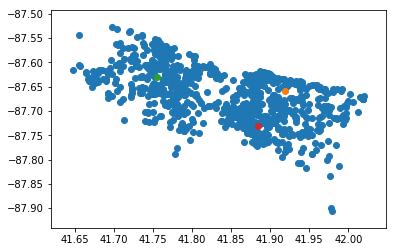

In [41]:

#points = np.array([[lat1, lon1], [lat2, lon2], ...])
nppoints = np.array(crime_sites)

# Must convert data to radians.

rads = np.radians(nppoints)
clusterer = HDBSCAN(min_cluster_size=5, metric='haversine')
cluster_labels = clusterer.fit_predict(nppoints)

### KNearestNeighbor Cluster of Crime Locations

clf = sklearn.cluster.KMeans(n_clusters=3, init="k-means++", n_init=10, max_iter=300, tol=0.0001, precompute_distances="auto", verbose=0, random_state=42)
clf.fit(nppoints)

plt.scatter(data.latitude, data.longitude)
for _ in clf.cluster_centers_:
    plt.scatter(_[0],_[1])

plt.show()
plt.close()

for _ in clf.cluster_centers_:
    #plt.scatter(_[0],_[1])
    m.add_child(folium.Marker(location=[_[0],_[1]],popup=(folium.Popup('CRIME CENTROID')),icon=folium.Icon(color='red',icon_color='black')))

m
#map.add_child(fg)

In [ ]:
dc_crime_data = "https://maps2.dcgis.dc.gov/dcgis/rest/services/FEEDS/MPD/MapServer/38/query?where=1%3D1&outFields=*&outSR=4326&f=json"

#38.995385, -77.126565
#38.796434, -76.914867

lat1 = 38.995385
lat2 = 38.796434
lon1 = -77.126565
lon2 = -76.914867

def generate_points(lat_grid, long_grid, lat1, lon1, lat2, lon2):
    lat_num_grids = lat_grid
    long_num_grids = long_grid

    chicago_x1 = 38.995385
    chicago_x2 = 38.796434
    chicago_y1 = -77.126565
    chicago_y2 = -76.914867

    lat_diff = abs(lat1-lat2)
    long_diff = abs(lon1 - lon2)

    lat_grid_size = lat_diff / lat_num_grids
    long_grid_size = long_diff/long_num_grids

    grid_x = [lat1 - (i*lat_grid_size) for i in range(lat_num_grids)]
    grid_y = [lon1 + (i*long_grid_size) for i in range(long_num_grids)]

    points = []
    for y in grid_y:
        for x in grid_x:
            points.append([x, y, x-lat_grid_size, y+long_grid_size])
    return points

def get_crime_data(c_url):    
    #import urllib.request, json, pprint 
    with urllib.request.urlopen(chicago_crime_url) as url:
        return json.loads(url.read().decode())
    
def generate_mid_points(points):
    mid_points = {}
    for id,_ in enumerate(points):
        a = [.5*(_[0]-_[2])+_[0], .5*(_[1]-_[3])+_[3]]
        mid_points[id]=a    
    return mid_points

def dc_block_parse(address):
    return address.replace('block of ', '') + "Washington, DC"

In [ ]:
points = generate_points(10, 10, lat1, lon1, lat2, lon2)
mid_points = generate_mid_points(points)
data = get_crime_data(dc_crime_data)

for crime in data:
    dis = {}
    #pprint.pprint(crime)
    
    try:
        if 'LATITUDE' in crime.keys():
            lo = float(crime['LATITUDE'])
            la = float(crime['LONGITUDE'])
        else:
            la, lo = get_lat_long_from_address(dc_block_parse(crime['BLOCK']))
    except:
        #print('failed to gaziteer')
        pass
    for mid in mid_points.keys():
        #calculate haversine between crime and mid_points
        #haversine(_[1], _[0], crime['longitude'], crime['latitude'])
        #haversine(lon1, lat1, lon2, lat2):
        #pprint.pprint(mid_points[mid])
        #pprint.pprint(crime)
        #print(mid_points[mid][1], mid_points[mid][0])
        #print(crime['longitude'], crime['latitude'])
        #print(crime.keys())
        
        try:
            dis[mid]=haversine(mid_points[mid][1], mid_points[mid][0], lo, la)
        except: 
            print('Failed Haversine')
            pass
    
    crime['distances']=dis  
    sorted_by_value = sorted(dis.items(), key=lambda kv: kv[1])
    #print(sorted_by_value)
    #print(sorted_by_value[0][0])
    crime_data[sorted_by_value[0][0]] = crime_data[sorted_by_value[0][0]] + 1
# allocate crime to grid point
# color grid squares by density

In [ ]:
m = folium.Map(location=[38.897515, -77.036621], zoom_start=14, tiles="OpenStreetMap")

for id, i in enumerate(points): 
    color = ""
    if crime_data[id] <= 2: color='green'
    elif crime_data[id] > 2 and crime_data[id] <= 4:color='yellow'
    elif crime_data[id] > 4 and crime_data[id] <= 10:color='orange'    
    else: color='red'
    folium.vector_layers.Rectangle(bounds = [(i[0],i[1]),(i[2], i[3])], popup=None, tooltip=None, fill_opacity=0.6, fill_color=color, color='black').add_to(m)
    #.features.RectangleMarker(bounds, color='black', weight=1, fill_color='black', fill_opacity=0.6, popup=None)
    #folium.features.RectangleMarker(bounds = [i[0],i[1],i[2], i[3]], color='black', weight=1, fill_color='black', fill_opacity=0.6, popup=None).add_to(m)
    #folium.features.RegularPolygonMarker(location=[i[0], i[3]], color='black', opacity=8, weight=1, fill_color='blue', fill_opacity=1, number_of_sides=4, rotation=45, radius=15, popup=None).add_to(m)
    
m


# if zoom level > 12 then show the crime dots

In [ ]:
crime_data